In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 
import numpy as np
db = mysql.connector.connect(host = 'localhost', username = 'root', password = 'root', database = 'ecommerce')
cur = db.cursor()


In [5]:
#list all unique cities where customers are located
query = """select distinct customer_city from customers"""
cur.execute(query) #excecute query
data = cur.fetchall() #fetching all data from query store in cursor
df = pd.DataFrame(data,columns=["Customer_city"])
df.head()

,Customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [6]:
#count the number of orders placed in 2017
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query) #excecute query
data = cur.fetchall() #fetching all data from query store in cursor
"Total orders are placed in 2017 are",data[0][0]

('Total orders are placed in 2017 are', 45101)

In [7]:
#find the total sales per category
query = """ select products.product_category category, round(sum(payments.payment_value),2)
sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id 
group by category"""
cur.execute(query) #excecute query
data = cur.fetchall() #fetching all data from query store in cursor
df=pd.DataFrame(data,columns = ["Category","Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


In [8]:
#calculate the percentage of orders that were paid in installments.
query = """ select (sum(case when payment_installments>=1 then 1 else 0 end ))/count(*)*100 from payments """
cur.execute(query) #excecute query
data = cur.fetchall() #fetching all data from query store in cursor
data

[(Decimal('99.9981'),)]

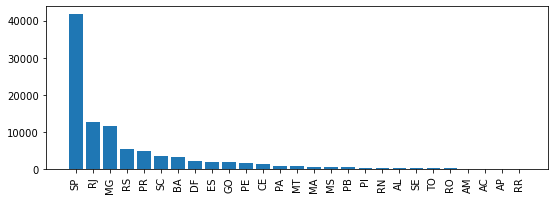

In [9]:
#count the number of customers from each state.
query = """select customer_state, count(customer_id) from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["States", "Count"])
df = df.sort_values(by = 'Count', ascending = False )
plt.figure(figsize = (9,3))
plt.bar(df['States'], df['Count'])
plt.xticks(rotation = 90)
plt.show()

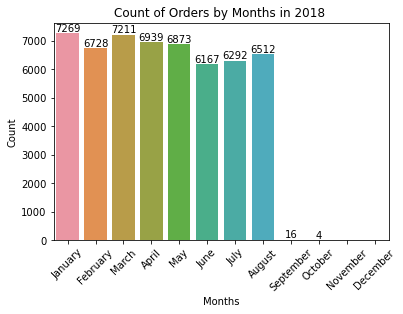

In [10]:
# Calculate the number of orders per month in 2018
query = """select monthname(order_purchase_timestamp) as monthname, count(order_id) as order_count
           from orders 
           where year(order_purchase_timestamp) = 2018 
           group by monthname"""
cur.execute(query)
data = cur.fetchall()

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Months", "Count"])

# Define the correct month order
order = ["January", "February", "March", "April", "May", "June", "July", 
         "August", "September", "October", "November", "December"]

# Plot
ax = sns.barplot(x="Months", y="Count", data=df, order=order)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018 ")
plt.show()


In [11]:
#Find the average number of products per order, grouped by customer city.
query = """with count_per_order as (
    select orders.order_id, orders.customer_id, count(order_items.order_id) as os
    from orders
    join order_items on orders.order_id = order_items.order_id
    group by orders.order_id, orders.customer_id
)
select customers.customer_city, round(avg(count_per_order.os), 2) as average_orders
from customers
join count_per_order on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_city","Average orders"])
df.head()

,Customer_city,Average orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


In [12]:
#calculate the percentage of total revenue contributed by each product category.
query = """ select products.product_category category, 
round((sum(payments.payment_value)/(select sum(payments.payment_value)from payments))*100,2) as sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id 
group by category order by sales_percentage desc"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns = ["Category","percentage_distribution"])
df.head()

,Category,percentage_distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


In [13]:
#identify the correlation between product price and the number of times a product has been purchased.
query = """select products.product_category, count(order_items.product_id) as Count, round(avg(order_items.price),2) as Average from products
join order_items on products.product_id = order_items.product_id
group by products.product_category;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Product_Category","Count","Price"])
df.head()

,Product_Category,Count,Price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14


In [14]:
#correlation between price and product count
product = df['Count']
price = df['Price']
a = np.corrcoef([product,price])
#there is neutral relation between count and price there is no impact 
print("The correlation between price and number of times a product has been purchased: \n",a[0][-1])

The correlation between price and number of times a product has been purchased: 
 -0.10631514167157562


In [20]:
query = """
SELECT *, 
       DENSE_RANK() OVER(ORDER BY revenue DESC) AS ranks
FROM (
    SELECT order_items.seller_id, 
           SUM(payments.payment_value) AS revenue 
    FROM order_items
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a;
"""

# Execute the query
cur.execute(query)
data = cur.fetchall()

# Optional: Display data using Pandas
df = pd.DataFrame(data, columns = ["Seller_ID","Revenue","Rank"])
df = df.head()


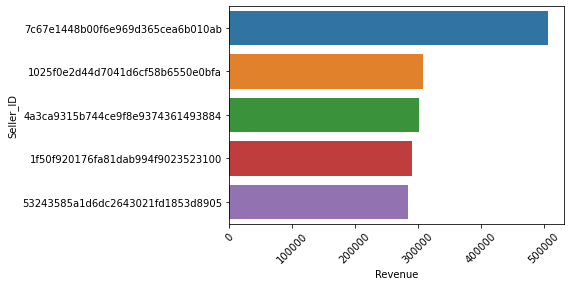

In [23]:
sns.barplot(y = "Seller_ID", x="Revenue",data=df)
plt.xticks(rotation=45)
plt.show ()

In [27]:
#calculate the moving average of order values for each customer over their order history.
query=""" select customer_id,order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp, 
payments.payment_value as payment from orders join payments
on orders.order_id = payments.order_id) as a;"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","TimeStamp","Price","Mov_avg"])
df.head()

,customer_id,TimeStamp,Price,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


In [2]:
#Calculate The cumulative sales per month for each year.
query=""" select years, months, monthly_sales, sum(monthly_sales) over (order by years,months) as cumulative_sales
from
(SELECT YEAR(orders.order_purchase_timestamp) AS years, 
MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value), 2) AS monthly_sales
FROM orders JOIN payments ON orders.order_id = payments.order_id
GROUP BY YEAR(orders.order_purchase_timestamp) , MONTH(orders.order_purchase_timestamp)
ORDER BY years , months) as a;
"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns = ["Years","Months","Monthly_Sales","Cumulative_sales"])
df = df.head()

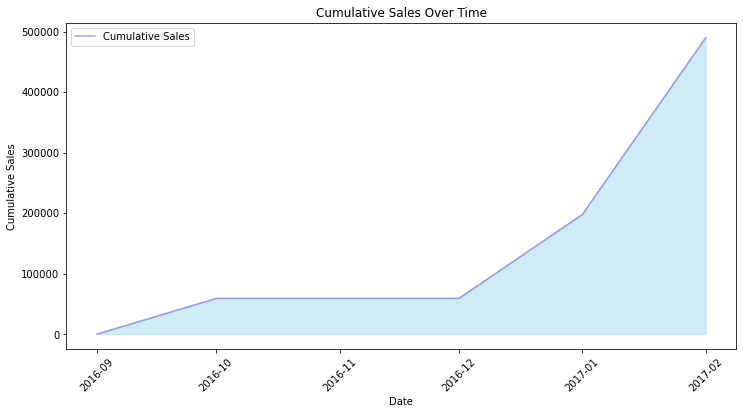

In [3]:
df['Date'] = pd.to_datetime(df[['Years', 'Months']].assign(DAY=1))

plt.figure(figsize=(12,6))
plt.fill_between(df['Date'], df['Cumulative_sales'], color="skyblue", alpha=0.4)
plt.plot(df['Date'], df['Cumulative_sales'], color="Slateblue", alpha=0.6, label='Cumulative Sales')

plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.title('Cumulative Sales Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [7]:
query = """
SELECT 
    year,
    total_sales,
    LAG(total_sales) OVER (ORDER BY year) AS previous_year_sales,
    ROUND(
        (total_sales - LAG(total_sales) OVER (ORDER BY year)) / LAG(total_sales) OVER (ORDER BY year) * 100,
        2
    ) AS growth_rate
FROM 
    (
        SELECT 
            YEAR(orders.order_purchase_timestamp) AS year,
            ROUND(SUM(payments.payment_value), 2) AS total_sales
        FROM 
            orders 
        JOIN 
            payments ON orders.order_id = payments.order_id
        GROUP BY 
            YEAR(orders.order_purchase_timestamp)
    ) AS yearly_sales
ORDER BY 
    year;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years", "Total_sales", "Previous_year_sales", "Growth_rate"])
df


,Years,Total_sales,Previous_year_sales,Growth_rate
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


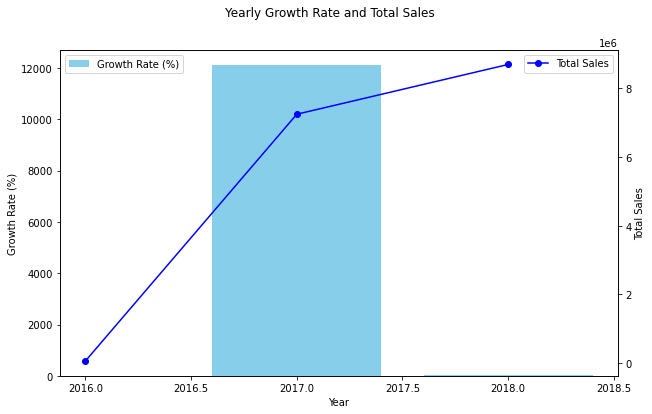

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for growth rate
ax1.bar(df['Years'], df['Growth_rate'], color='skyblue', label='Growth Rate (%)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Growth Rate (%)')
ax1.legend(loc="upper left")

# Line plot for total sales
ax2 = ax1.twinx()
ax2.plot(df['Years'], df['Total_sales'], color='b', marker='o', linestyle='-', label='Total Sales')
ax2.set_ylabel('Total Sales')
ax2.legend(loc="upper right")

fig.suptitle('Yearly Growth Rate and Total Sales')
plt.show()


In [18]:
#Calculate the retention rate of customes, defined as the percentage of customers who make another purchase within 6 month of thier first purchase

query = """
WITH first_order AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM 
        customers 
    JOIN 
        orders ON customers.customer_id = orders.customer_id 
    GROUP BY 
        customers.customer_id
),
next_order AS (
    SELECT 
        a.customer_id,
        COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM 
        first_order AS a
    JOIN 
        orders ON orders.customer_id = a.customer_id 
        AND orders.order_purchase_timestamp > a.first_order
        AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY 
        a.customer_id
)
SELECT 
    100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id)) AS percentage
FROM 
    first_order AS a
LEFT JOIN 
    next_order AS b ON a.customer_id = b.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data )
df

,0
0,None


In [23]:
#identify the top 3 customers who spent the most money in each year.
query = """
SELECT 
    year,
    customer_id,
    payment,
    ranks
FROM 
    (
        SELECT 
            YEAR(orders.order_purchase_timestamp) AS year,
            orders.customer_id,
            ROUND(SUM(payments.payment_value), 2) AS payment,
            DENSE_RANK() OVER(PARTITION BY YEAR(orders.order_purchase_timestamp) 
                              ORDER BY SUM(payments.payment_value) DESC) AS ranks
        FROM 
            orders
        JOIN 
            payments ON orders.order_id = payments.order_id
        GROUP BY 
            year, orders.customer_id
    ) AS a
WHERE 
    ranks <= 3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", "Customer_ID", "Payment", "Ranks"])
df


,Year,Customer_ID,Payment,Ranks
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


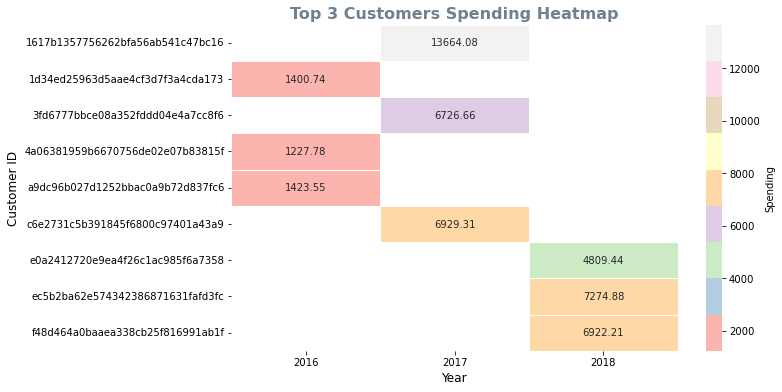

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it’s pivoted for the heatmap
pivot_df = df.pivot('Customer_ID', 'Year', 'Payment')

plt.figure(figsize=(10, 6))

sns.heatmap(pivot_df, annot=True, cmap="Pastel1", fmt=".2f", cbar_kws={'label': 'Spending'}, linewidths=0.5)

plt.title('Top 3 Customers Spending Heatmap', fontsize=16, fontweight='bold', color='slategray')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Customer ID', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()
